## Differentiable predictive control: NODE-style system manipulation

Differentiable predictive control (DPC) is similar to model predictive control (MPC) in that we are searching for control actions $u(t)$ which minimize a certain control loss such that the behavior of a given system is manipulated in a desired fashion. While neglecting system constraints, the DPC problem formulation is

$$
\begin{align*}
\min_{w} \mathcal{L}  &= \sum_{k=1}^N l(y[k], u[k], r[k]),\\
\mathrm{s.t.} \quad \dot{x}(t) &= f(x(t), u(t)),\\
y(t) &= g(x(t), u(t)),\\
t[k+1] &= t[k] + \Delta t,\\
x_0 &= x[0] = x(0),\\
u(t) &= \pi_w(y[k], r[k]) 
\end{align*}
$$

with $l(\cdot)$ being some stage costs depending on the system output $y$, control actions $u$ and the reference $r$ (e.g., mean squared error between reference and output). In addition to the usual state-space description, the **control policy** $\pi_w(y[k], r[k])$ with parameters $w$ is of prime importance to the DPC framework. The policy $\pi_w(\cdot)$ maps system output and reference observations to control actions and can be trained in the usual supervised machine learning manner by minimizing the control loss.

Hence, the presented problem is algorithmically related to the neural ordinary differential (NODE) approach, as we utilize algorithmic differentiation to receive control policy parameter updates based on an end-to-end differentiable representation of our control problem. The only conceptual difference is that in DPC we search for a system manipulation strategy (control policy) assuming an available model description, either based on a priori knowledge or based on a previous data-driven system identification (e.g., using NODE).  

### Example: Duffing oscillator

In analogy to the previous MPC example, we will again study the Duffing oscillator
$$ \frac{\mathrm{d}}{\mathrm{d}t} \begin{bmatrix} x_1(t) \\ x_2(t) \end{bmatrix} = \begin{bmatrix} x_2(t) \\ -\delta x_2(t) -\alpha x_1(t) - \beta x_1^3(t) + u(t) \end{bmatrix}, \quad x(t=0) = x_0 \neq 0 . $$
For sake of simplicity we assume $y(t)=x(t)$ and our objective is to stabilize the system in the origin, i.e., $$r(t) = \begin{bmatrix}0 \\ 0\end{bmatrix} \quad \forall t>0.$$
Consequently, we form a mean squared error loss on the reference deviation $$l(y[k], u[k], r[k]) = \|y[k] - r[k]\|_2^2 . $$ 
The control policy $\pi_w(\cdot)$ will be represented by an artificial neural network (ANN) which will be trained in the following.

In [15]:
using OrdinaryDiffEq, Lux, Random, ComponentArrays, Plots, LaTeXStrings
using SciMLSensitivity, Optimization, Zygote, OptimizationFlux, LinearAlgebra

We start formulating the system description:

In [2]:
function duffing(x, p, t) # Duffing oscillator ODE
    u = ann([x; r(t); x - r(t)], p, st_ANN)[1][1]
    return [x[2]; - δ * x[2] - ɑ * x[1] - β * x[1]^3 + u];
end;

In [3]:
const ɑ, β, δ = -1f0, 1f0, 0.1f0; # Duffing oscillator parameters

General simulation parameters:

In [4]:
NF = Float32 
x0 = [1f0,0.5f0]
tspan = (0.f0,20f0)
dt = 0.01f0  # sampling timex0_NODE = [0f0; 0f0] # initial temperature
datasize =Int(round(tspan[2]./dt)+2) # number of data points
tsteps = range(tspan[1], tspan[2]; length=datasize); # time vector 

Define the reference signal:

In [5]:
r(t) = NF.([t*0; t*0]) # reference trajectory (origin)
r_vec = r.(tsteps); # reference trajectory vector (discrete time)

The control policy $\pi_w(\cdot)$ has six inputs as it observes the two states / outputs, the two reference signals as well as the difference between the two signals as a simple features derived from those signals. The according ANN has one output which is activated by a `tanh()` function such that the control action is naturally limited to $u(t)\in [-1, \,\, 1]$.

In [6]:
rng = MersenneTwister(42) # seeding random number generator
ann = Lux.Chain(Lux.Dense(6, 10, tanh; init_weight=glorot_uniform(;gain = 0.1)), Lux.Dense(10, 1, tanh; init_weight=glorot_uniform(;gain = 0.1))); # define neural network architecture
w_ANN, st_ANN =Lux.setup(rng, ann); # initialize neural network parameters and state
w_ANN = ComponentArray(w_ANN); # initial guess parameters for difference equation approach (ComponentArray)

In [7]:
prob = ODEProblem(duffing, x0, tspan, w_ANN); # define ODE problem

In [8]:
function predict(p) # prediction function for ODE
    reduce(hcat, solve(prob, Tsit5(); p = p, saveat = tsteps).u)
end;

In [9]:
function loss_DPC(p) # loss function for DPC
    return sum(abs2, predict(p) - reduce(hcat, r_vec)) # mean squared error
end;

In [10]:
losses = Float32[]
callback_online = function (p, l)
    push!(losses, l)
    if length(losses) % 25 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end;

In [11]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss_DPC(x), adtype) # define optimization function
optprob = Optimization.OptimizationProblem(optf, w_ANN); # define optimization problem

In [12]:
res = Optimization.solve(optprob, Adam(0.25);   maxiters=250, maxtime = 60.0, callback=callback_online); # solve optimization problem for DPC

Current loss after 25 iterations: 213.72304
Current loss after 50 iterations: 213.57077
Current loss after 75 iterations: 212.93816
Current loss after 100 iterations: 212.41771
Current loss after 125 iterations: 212.04326
Current loss after 150 iterations: 211.56818
Current loss after 175 iterations: 211.01479
Current loss after 200 iterations: 210.6103
Current loss after 225 iterations: 210.23198
Current loss after 250 iterations: 209.85411


Plot the results:

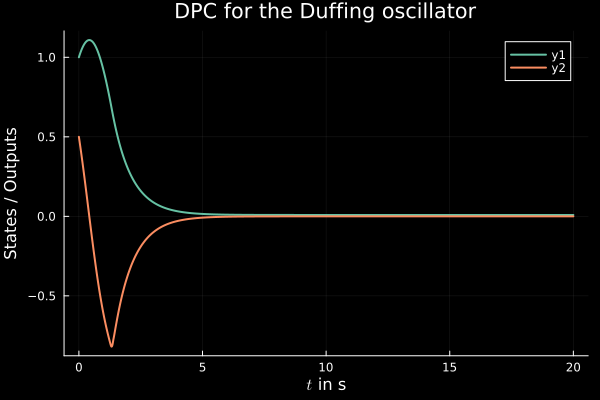

In [13]:
plot(tsteps, predict(res.u)', background_color="#000000", lw=2, palette = :Set2_5, title = "DPC for the Duffing oscillator", xlabel = L"$t$ in s", ylabel = "States / Outputs")

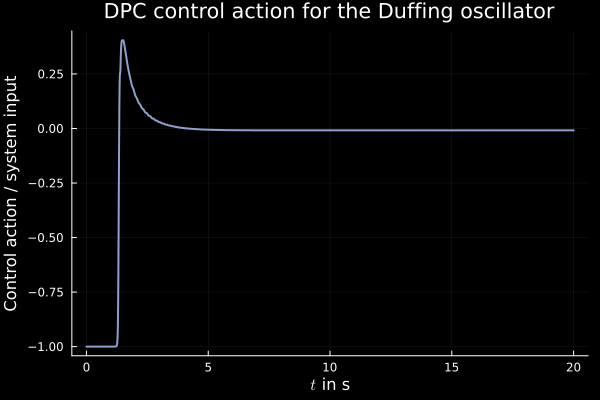

In [14]:
using DataInterpolations
x1_interp = AkimaInterpolation(predict(res.u)[1,:], tsteps)
x2_interp = AkimaInterpolation(predict(res.u)[2,:], tsteps) 
plot(tsteps, map(t -> ann([[x1_interp(t); x2_interp(t)]; r(t); [x1_interp(t); x2_interp(t)] - r(t)], res.u, st_ANN)[1][1], tsteps), 
    background_color="#000000", lw=2, color = 3, palette = :Set2_5, title = "DPC control action for the Duffing oscillator", 
    xlabel = L"$t$ in s", ylabel = "Control action / system input", label = false)